# Indlæser pakker

In [67]:
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path # To make relative paths

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error as mse
import statistics as stat
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Sætter paths

In [68]:
my_path = Path.cwd() # Path to current directory
project_path = my_path.parents[0] # Path to project directory
data_path = project_path / 'Data' # Path to data folder
figure_path = project_path / 'Figures' # Path to data folder

data_path

WindowsPath('C:/Users/nld/Introduction to Data Science/Exam Project/Data')

# Indlæser data

In [70]:
# Samlet data
final_df = pd.read_parquet(data_path/'ML_Dataset.parquet', engine='pyarrow')
final_df

,geometry,job_density,distance_to_nearest_station,nearest_station_name,departures_per_hour,distance_to_job_center,latitude,longitude,propertyType,energyClass,priceCash,selfsale,rooms,size,lotSize,buildYear,city,zipCode,area,exp,basementSize,businessArea,nonPremiumDiscrete,cleanStreet,municipality
0,POINT (9.73815 55.05967),17.0,16.529831,Sønderborg,0.0,52.754986,55.05967,9.73815,1,-,395000,False,6.0,128,1027.0,1954.0,Nordborg,6430,8,836,57,0.0,False,Kirkegade,540.0
1,POINT (10.018139999999999 57.34863000000001),10.0,4.616035,Vrå,3.0,35.003693,57.34863,10.01814,1,F,525000,False,4.0,132,834.0,1925.0,Vrå,9760,11,943,4,NaN,False,Hovedgaden,860.0
2,POINT (8.160810000000001 56.56825),3.0,8.887970,Lemvig,1.0,71.358872,56.56825,8.16081,1,E,1295000,False,10.0,253,2442.0,1904.0,Lemvig,7620,9,1542,9,0.0,False,Harboørevej,665.0
3,POINT (8.62765 56.881159999999994),0.0,8.210290,Sjørring,1.0,80.416299,56.88116,8.62765,1,C,1995000,False,8.0,197,1260.0,1972.0,Thisted,7700,11,1497,49,0.0,False,Skyumvej,787.0
4,POINT (8.53851 56.51651),24.0,2.757882,Humlum,1.0,51.470776,56.51651,8.53851,1,D,945000,False,3.0,155,784.0,1968.0,Struer,7600,9,1080,0,0.0,False,Havremarken,671.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43317,POINT (12.52363 55.73177),1432.0,0.854964,Vangede,14.0,4.918679,55.73177,12.52363,9,C,6995000,False,3.0,91,0.0,1929.0,Dyssegård,2870,2,5063,91,0.0,False,Dyssegårdsvej,157.0
43318,POINT (10.198739999999999 56.14742),518.0,0.477290,Aarhus H,4.0,1.232978,56.14742,10.19874,9,D,3498000,False,3.0,72,0.0,1902.0,Aarhus C,8000,10,3412,0,0.0,False,Skt Anna Gade,751.0
43319,POINT (9.4821 55.25326999999999),36.0,11.249660,Vojens,2.0,28.326666,55.25327,9.48210,9,C,795000,False,2.0,79,0.0,1900.0,Haderslev,6100,8,362,0,0.0,False,Slagtergade,510.0
43320,POINT (12.55833 55.709469999999996),1432.0,0.652416,Ryparken,38.0,2.999852,55.70947,12.55833,9,C,5750000,False,2.0,56,0.0,1921.0,København Ø,2100,1,2611,56,NaN,False,Rudolph Berghs Gade,101.0


# ML

## Klargør data til ML

In [71]:
# Dividerer pris med 1 mio.
final_df['priceMil'] = final_df['priceCash']/1000000

In [72]:
# Udvælger variable
model_df = final_df[['priceMil', 'job_density', 'distance_to_nearest_station', 'departures_per_hour', 
                    'distance_to_job_center', 'propertyType', 'energyClass', 
                     'rooms', 'size', 'lotSize', 'basementSize', 'exp',
                   'buildYear', 
                     'municipality']].reset_index(drop=True)

In [73]:
# Fjerner observationer med fejl i expenses
model_df = model_df[(model_df['exp']<100000) & (model_df['exp']!=0)]
len(model_df)


42709

In [74]:
# Make dummy variables
# Create dummy variables for propertyType, energyClass, and area
model_df_dummies = pd.get_dummies(model_df, columns=['propertyType', 'energyClass', 'municipality'], drop_first=True)

In [75]:
# Define x and y variables
X = model_df_dummies.drop('priceMil', axis=1)  # Features (drop the target variable)
y = model_df_dummies['priceMil']               # Target variable

In [76]:
# 1. Split data data into development and test
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

In [77]:
X_dev = X_dev.reset_index(drop = True)
y_dev = y_dev.reset_index(drop = True)


## Ridge

### 1. Cross validation
Laver k-fold cross validation med forskellige parametre af lambda for at finde optimalt lambda

In [61]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=2)
folds = list(kfolds.split(X_dev, y_dev))
folds

# Define lambds
lambdas =  np.logspace(0, 10, 12)

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        # Make pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=161193))   
        # Split development data into training and validation data
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        
        # Train the model using pipe_lasso
        pipe_ridge.fit(X_train, y_train)
        
        # Calculate MSE for validation data
        mseCV_.append(mse(pipe_ridge.predict(X_val), y_val))    
        print(mseCV_)
    
    # Calculate average mean squared error in validation data
    avg_mse = stat.mean(mseCV_) 

    # Store result    
    mseCV.append(avg_mse) 
    


[6.800329585638424]
[6.800329585638424, 6.5227436217373596]
[4.040318668347449]
[4.040318668347449, 5.724866939285062]
[2.87038410800573]
[2.87038410800573, 4.454146779710666]
[2.702936739607124]
[2.702936739607124, 4.183081056851738]
[2.613337577376709]
[2.613337577376709, 3.857970260728911]
[3.464102662647769]
[3.464102662647769, 2.9739311646603546]
[7.786109503972409]
[7.786109503972409, 6.04085936385118]
[13.264247504472106]
[13.264247504472106, 11.81763586640254]
[14.779979827563942]
[14.779979827563942, 13.511006580783537]
[14.99551136176377]
[14.99551136176377, 13.75364826070497]
[15.022585751625753]
[15.022585751625753, 13.784156915452067]
[15.025931393851243]
[15.025931393851243, 13.78792737575366]


In [66]:
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)
lambdaCV

# Find the index of the minimum RMSE for the test set
min_mse_val_index = np.argmin(mseCV)

# Find the corresponding lambda value
optimal_lambda = lambdas[min_mse_val_index]

# Find the corresponding minimum RMSE value
min_mse_val = mseCV[min_mse_val_index]

print(f"The optimal lambda (alpha) that gives the lowest test AMSE is: {optimal_lambda}")
print(f"The lowest test AMSE is: {min_mse_val}")
lambdaCV

ValueError: Shape of passed values is (12, 1), indices imply (25, 1)

In [78]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import validation_curve

# Define lambds
lambdas =  np.logspace(0, 10, 25)

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_ridge,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=5)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

# YAY we get the same result as in the previous excercise

lambda
825.404185    2.593241
Name: Validation, dtype: float64


### 2. Plotter MSE for forskellige værdier af lambda

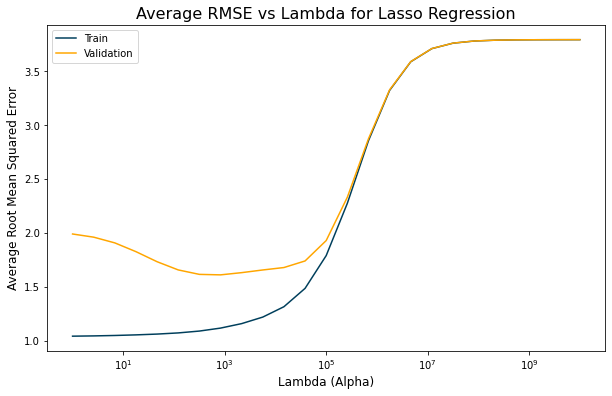

In [79]:
# Plot average MSE for train and test data against different values of lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, np.sqrt(mse_score['Train']), label='Train', color = '#003f5c')
plt.plot(lambdas, np.sqrt(mse_score['Validation']), label='Validation', color = '#ffa600')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)', fontsize = 12)
plt.ylabel('Average Root Mean Squared Error', fontsize = 12)
plt.title('Average RMSE vs Lambda for Lasso Regression', fontsize = 16)
plt.legend()
# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_validation_curve_title.jpg', dpi=300, bbox_inches='tight')


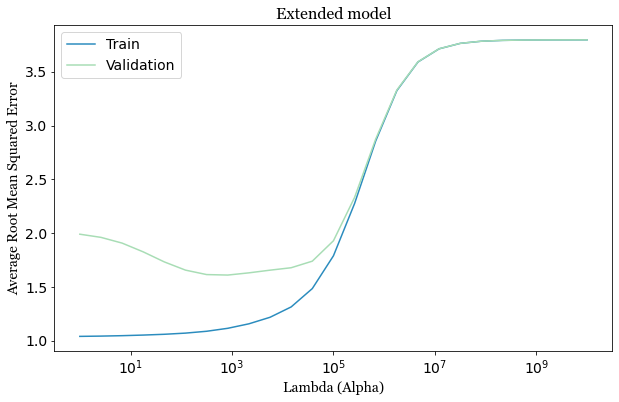

In [93]:
# Assuming lambdas and mse_score are already defined
plt.figure(figsize=(10, 6))
plt.plot(lambdas, np.sqrt(mse_score['Train']), label='Train', color='#2b8cbe')
plt.plot(lambdas, np.sqrt(mse_score['Validation']), label='Validation', color='#a8ddb5')
plt.xscale('log')
plt.xlabel('Lambda (Alpha)', font='Georgia', fontsize=14)
plt.ylabel('Average Root Mean Squared Error', font='Georgia', fontsize=14)
plt.title('Extended model', font='Georgia', fontsize=16)
plt.legend(fontsize=14)  # Set legend font to Georgia
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_validation_curve.jpg', dpi=300, bbox_inches='tight')


### 3. Fitter model på hele træningsdata

In [81]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Suppose you have chosen a specific lambda value from the mse_score DataFrame
chosen_lambda = mse_score.Validation.idxmin()  # Selects the lambda with the smallest validation error

# Recreate the pipeline (if not already defined)
pipe_ridge = make_pipeline(PolynomialFeatures(degree = 2, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=chosen_lambda, random_state=161193))   

# Fit the model on the entire development set (or a training set)
pipe_ridge.fit(X_dev, y_dev)

# Access the coefficients (beta parameters)
beta_parameters = pipe_ridge.named_steps['ridge'].coef_

# Optionally, you can also access the intercept
intercept = pipe_ridge.named_steps['ridge'].intercept_

print("Beta coefficients:", beta_parameters)
print("Intercept:", intercept)


Beta coefficients: [ 0.10038569  0.00205534  0.11583358 ... -0.01698551  0.
 -0.04318547]
Intercept: 3.1429920702795684


### 4. Tester på model

In [82]:
from sklearn.metrics import r2_score

# Beregner MSE på baggrund af testdata
mse(pipe_ridge.predict(X_test), y_test)

# Calculate predictions
y_pred = pipe_ridge.predict(X_test)

# Beregner MSE på baggrund af testdata
print(f"MSE: {mse(y_pred, y_test):.4f}")
print(f"R2: {r2_score(y_pred, y_test, sample_weight=None, multioutput=None):.4f}")

# print(f"MSE: {mse(y_test, y_pred):.4f}")
# print(f"R2: {r2_score(y_test, y_pred, sample_weight=None, multioutput=None):.4f}")



MSE: 3.2872
R2: 0.7510


### 5. Finder parameterestimater

In [92]:
#  Retrieve the feature names from the PolynomialFeatures step
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(input_features=X_dev.columns)

# # Identify the non-zero coefficients
non_zero_indices = beta_parameters != 0
non_zero_coefficients = beta_parameters[non_zero_indices]

# Get corresponding feature names for non-zero coefficients
selected_features = feature_names[non_zero_indices]

# Create a DataFrame for easy visualization
non_zero_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': non_zero_coefficients
})

# print(non_zero_df)
non_zero_df.sort_values('Coefficient')

,Feature,Coefficient
1078,exp propertyType_3,-0.467970
1186,exp municipality_846.0,-0.381061
396,departures_per_hour municipality_157.0,-0.274628
1079,exp propertyType_6,-0.239496
964,basementSize propertyType_3,-0.187937
...,...,...
1088,exp energyClass_C,0.325881
728,size lotSize,0.330684
612,rooms exp,0.384248
1076,exp buildYear,0.646939


In [84]:
# Create a DataFrame for easy visualization
all_betas = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': beta_parameters
})
all_betas[0:121][all_betas[0:121]['Coefficient']!=0].sort_values('Coefficient')

,Feature,Coefficient
85,municipality_561.0,-0.066769
103,municipality_740.0,-0.065925
3,distance_to_job_center,-0.050516
77,municipality_479.0,-0.046480
89,municipality_580.0,-0.040578
...,...,...
0,job_density,0.100386
2,departures_per_hour,0.115834
6,lotSize,0.118529
5,size,0.200767


### 6. Plotter predicted values med actual prices

In [85]:
y_predict = pipe_ridge.predict(X_test)

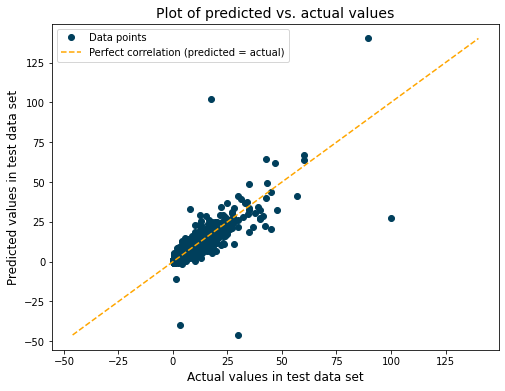

In [86]:
# Create the plot
plt.figure(figsize=(8, 6))

# You can use either a line plot or a scatter plot depending on your data
plt.plot(y_test, y_predict, 'o', label='Data points', color = '#003f5c')  # 'o' for scatter plot
# plt.scatter(y_test, y_pred, label='Data points')  # Alternative scatter plot

# Plot the perfect correlation line (y = x)
min_value = min(min(y_test), min(y_predict))
max_value = max(max(y_test), max(y_predict))

plt.plot([min_value, max_value], [min_value, max_value], color='#ffa600', label='Perfect correlation (predicted = actual)', linestyle='--')


# Add labels and title
plt.xlabel('Actual values in test data set', fontsize = 12)
plt.ylabel('Predicted values in test data set', fontsize = 12)
plt.title('Plot of predicted vs. actual values', fontsize = 14)

# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_prediction_title.jpg', dpi=300, bbox_inches='tight')


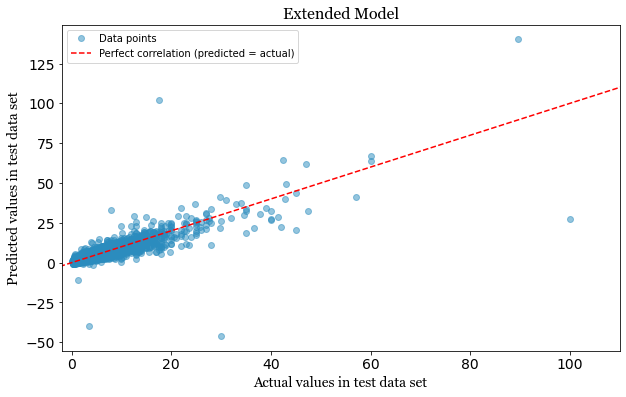

In [99]:
# Create the plot
plt.figure(figsize=(10, 6))

# You can use either a line plot or a scatter plot depending on your data
plt.plot(y_test, y_predict, 'o', label='Data points', color = '#2b8cbe', alpha = 0.5)  # 'o' for scatter plot
# plt.scatter(y_test, y_pred, label='Data points')  # Alternative scatter plot

# Plot the perfect correlation line (y = x)
min_value = min(min(y_test), min(y_predict))
max_value = max(max(y_test), max(y_predict))

plt.plot([min_value, max_value], [min_value, max_value], color='red', label='Perfect correlation (predicted = actual)', linestyle='--')


# Add labels and title
plt.xlabel('Actual values in test data set', font = 'Georgia', fontsize = 14)
plt.ylabel('Predicted values in test data set', font = 'Georgia', fontsize = 14)
plt.title('Extended Model', font = 'Georgia', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-2,110)
# plt.ylim(-2,110)


# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_prediction.jpg', dpi=300, bbox_inches='tight')


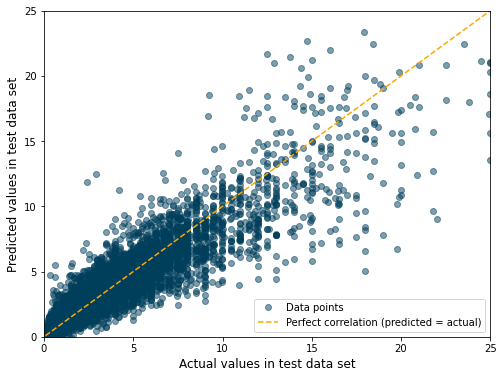

In [48]:
# Create the plot
plt.figure(figsize=(8, 6))

# You can use either a line plot or a scatter plot depending on your data
plt.plot(y_test, y_predict, 'o', label='Data points', 
         color = '#003f5c', alpha = 0.5)  # 'o' for scatter plot
# plt.scatter(y_test, y_pred, label='Data points')  # Alternative scatter plot

# Plot the perfect correlation line (y = x)
min_value = min(min(y_test), min(y_predict))
max_value = max(max(y_test), max(y_predict))

plt.plot([min_value, max_value], [min_value, max_value], color='#ffa600', label='Perfect correlation (predicted = actual)', linestyle='--')


# Add labels and title
plt.xlabel('Actual values in test data set', fontsize = 12)
plt.ylabel('Predicted values in test data set', fontsize = 12)
plt.xlim(0,25)
plt.ylim(0,25)
# Add a legend
plt.legend()

# Save the plot as a PNG file
plt.savefig(figure_path/'ridge_full_model_prediction_25.jpg', dpi=300, bbox_inches='tight')


In [ ]:
# Næste skridt:
# 1. Fit model på hele træningsdata
# 2. Predict på test data og regn RMSE
# 3. Sammenlign med andre fx Ridge
# 4. Plot predicted og actual prices